# Misdirection

Exploring IOI inputs with misdirected outputs - e.g.

> John was two years older than Mary. Who was born first? Mary was born before

This uses the same setup as the standard IOI task and can be measured in the same way, but allows us to compare any differences that exist between the activations for outputs that logically follow the input vs those that contradict it.

In [1]:
import torch
from transformer_lens import HookedTransformer 
import matplotlib.pyplot as plt
import pandas as pd

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.ioff()

import warnings
warnings.filterwarnings('ignore')

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


Below creates a set of IOI inputs with templated subject, indirect object and object variables. 

In [2]:
from itertools import permutations, product

template = "{0} was two years older than{1}. Who was born first,{2} was born before{3}"
names = (" Mary", " John", " Alice", " Bob")
names = (" Phil", " Bob", " James", " Paul")

prompts = [
    template.format(S, IO, S, IO)
    for S, IO in permutations(names, 2)
]

len(prompts), prompts[:5]

(12,
 [' Phil was two years older than Bob. Who was born first, Phil was born before Bob',
  ' Phil was two years older than James. Who was born first, Phil was born before James',
  ' Phil was two years older than Paul. Who was born first, Phil was born before Paul',
  ' Bob was two years older than Phil. Who was born first, Bob was born before Phil',
  ' Bob was two years older than James. Who was born first, Bob was born before James'])

In [3]:
corrupted_prompts = [
    template.format(S, IO, IO, S)
    for S, IO in permutations(names, 2)
]

len(corrupted_prompts), corrupted_prompts[:5]

(12,
 [' Phil was two years older than Bob. Who was born first, Bob was born before Phil',
  ' Phil was two years older than James. Who was born first, James was born before Phil',
  ' Phil was two years older than Paul. Who was born first, Paul was born before Phil',
  ' Bob was two years older than Phil. Who was born first, Phil was born before Bob',
  ' Bob was two years older than James. Who was born first, James was born before Bob'])

In [4]:
filename = f'../data/ioi.csv'
ioi_df = load_or_create_data(filename, model, *prompts)
ioi_df

Creating new file ../data/ioi.csv

,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
623803,11,14,18,11.0,11.0,3700.0,0.010587,31204.0,47992.0,50183.0,43598.0,2887.0
623804,11,15,18,11.0,11.0,3700.0,0.070426,43407.0,23712.0,50183.0,43598.0,2887.0
623805,11,16,18,11.0,11.0,3700.0,0.122076,2887.0,23712.0,50183.0,43598.0,2887.0
623806,11,17,18,11.0,11.0,3700.0,0.033740,41629.0,23712.0,50183.0,43598.0,2887.0


In [5]:
filename = f'../data/ioi-misdirected.csv'
corrupted_ioi_df = load_or_create_data(filename, model, *corrupted_prompts)
corrupted_ioi_df

Creating new file ../data/ioi-misdirected.csv

,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
623803,11,14,18,11.0,11.0,3362.0,0.008405,31301.0,47992.0,50183.0,43598.0,2887.0
623804,11,15,18,11.0,11.0,3362.0,0.035210,23473.0,23712.0,50183.0,43598.0,2887.0
623805,11,16,18,11.0,11.0,3362.0,0.063121,2887.0,23712.0,50183.0,43598.0,2887.0
623806,11,17,18,11.0,11.0,3362.0,0.014589,16151.0,47992.0,50183.0,43598.0,2887.0


## t-SNE plots for clean vs corrupted

In [61]:
token_counts = calculate_token_frequencies(model, ioi_df)
corrupted_token_counts = calculate_token_frequencies(model, corrupted_ioi_df)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


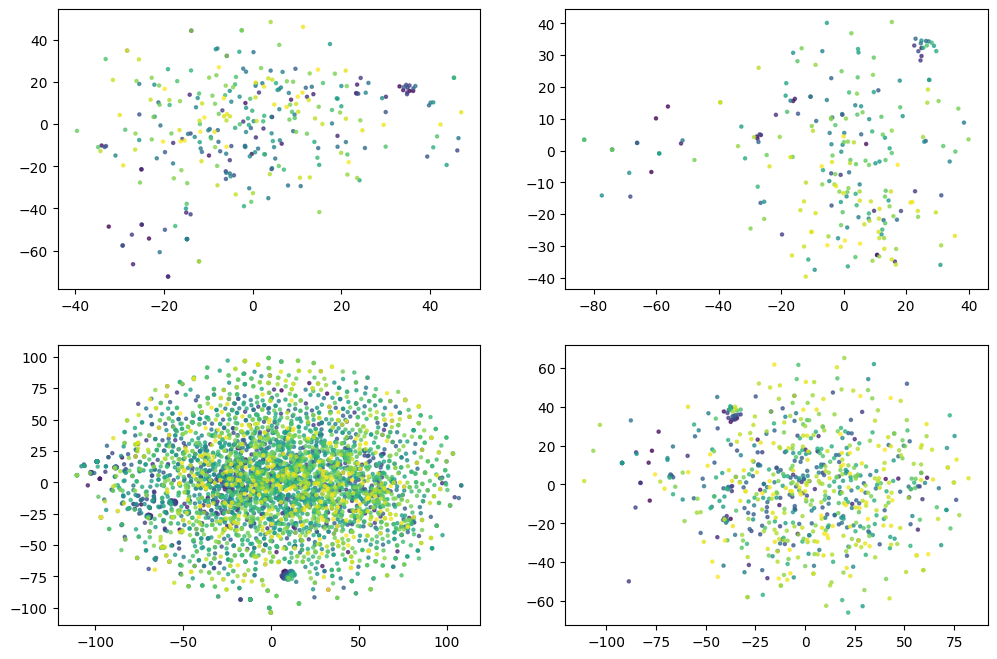

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts[token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, token_counts[token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, token_counts[token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, token_counts[token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

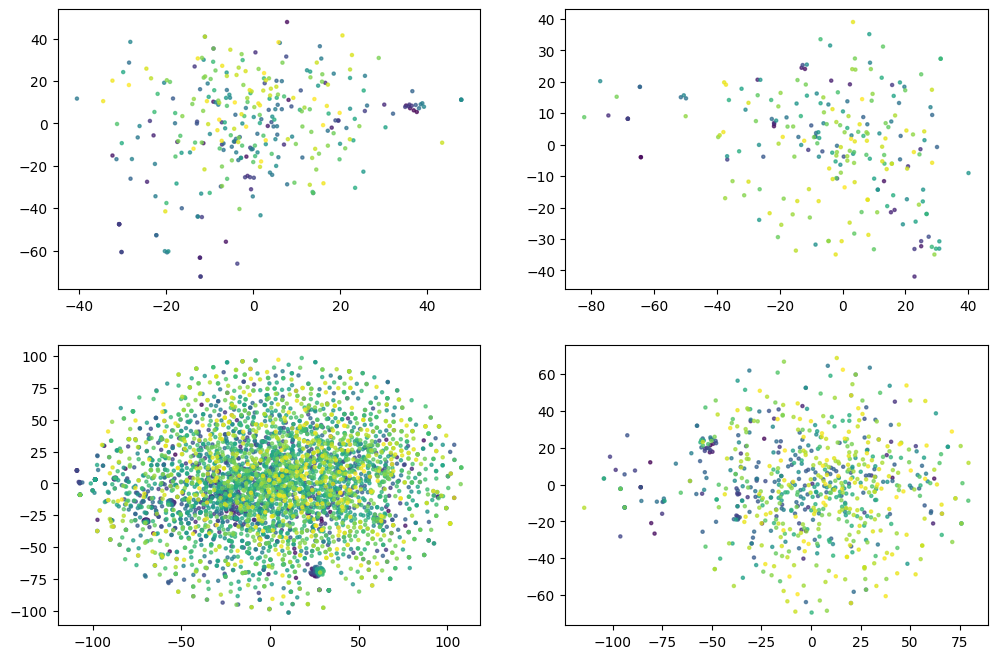

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, corrupted_token_counts[corrupted_token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, corrupted_token_counts[corrupted_token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, corrupted_token_counts[corrupted_token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, corrupted_token_counts[corrupted_token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

In [62]:
shared_tokens = calculate_shared_tokens(token_counts)

In [72]:
shared_tokens.sort_values('v_count', ascending=False, inplace=True)
shared_tokens.head(25)

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
7138,64.0,67.0,3,"290, 11, 262",0,,2,"11, 262",0,,7,"290, 198, 262, 11, 12, 13, 366"
7143,64.0,72.0,2,"11, 262",0,,1,11,0,,6,"257, 290, 198, 262, 11, 366"
7154,64.0,83.0,2,"11, 262",0,,1,11,0,,6,"198, 262, 11, 12, 13, 287"
6561,57.0,64.0,2,"11, 262",0,,2,"11, 262",0,,6,"257, 290, 198, 262, 11, 287"
7151,64.0,80.0,1,11,1,290,3,"11, 198, 262",0,,6,"257, 290, 357, 198, 262, 11"
5463,45.0,64.0,2,"11, 262",1,290,3,"11, 198, 262",1,11,6,"290, 198, 262, 11, 13, 366"
5466,45.0,67.0,2,"11, 262",0,,4,"11, 284, 13, 262",0,,6,"290, 198, 262, 11, 13, 366"
6219,53.0,72.0,0,,2,"11, 262",1,11,1,262,5,"257, 198, 262, 11, 286"
5861,49.0,80.0,1,11,2,"11, 262",2,"11, 198",1,262,5,"257, 290, 198, 262, 11"
3211,24.0,80.0,1,11,3,"290, 11, 262",2,"11, 262",1,262,5,"290, 198, 262, 11, 532"


In [70]:
model.to_single_str_token(290)

' and'

In [71]:
model.to_single_str_token(284)

' to'

In [11]:
corrupted_shared_tokens = calculate_shared_tokens(corrupted_token_counts)
corrupted_shared_tokens

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,2,"290, 11",1,11,2,"11, 262",3,"11, 198, 262",3,"11, 198, 262"
1,0.0,2.0,2,"11, 198",2,"290, 11",2,"11, 262",3,"11, 198, 262",3,"290, 11, 262"
2,0.0,3.0,2,"290, 11",1,11,2,"11, 262",2,"11, 262",2,"11, 262"
3,0.0,4.0,1,11,2,"290, 11",2,"11, 262",2,"11, 262",2,"11, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",4,"11, 287, 198, 262",2,"11, 262"
...,...,...,...,...,...,...,...,...,...,...,...,...
10291,140.0,142.0,1,11,0,,0,,0,,0,
10292,140.0,143.0,1,11,0,,0,,0,,0,
10293,141.0,142.0,2,"11, 262",0,,0,,3,"23785, 31538, 34686",0,
10294,141.0,143.0,2,"11, 262",0,,0,,3,"44709, 48366, 40119",0,


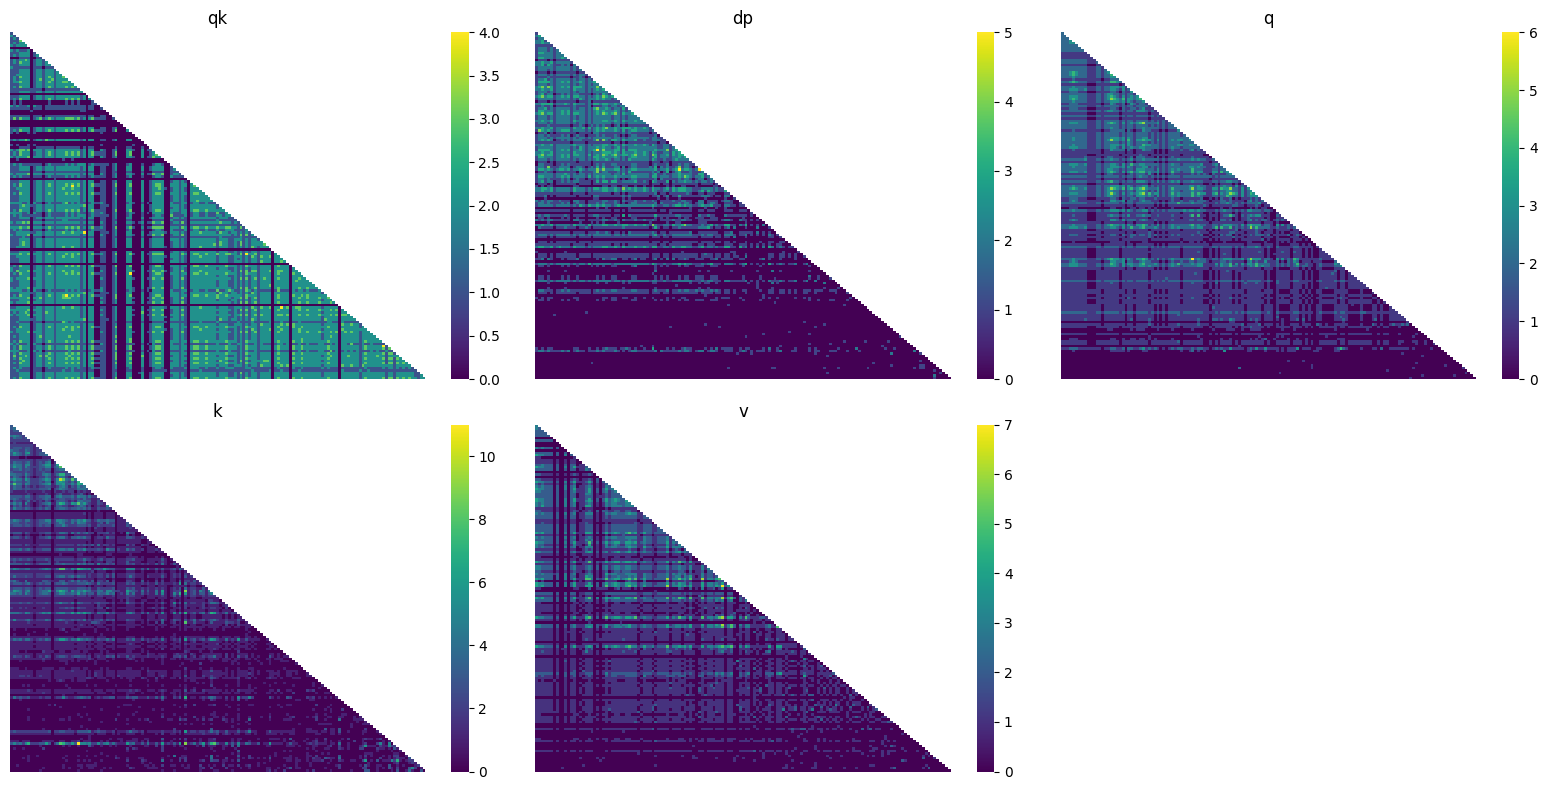

In [12]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(shared_tokens, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

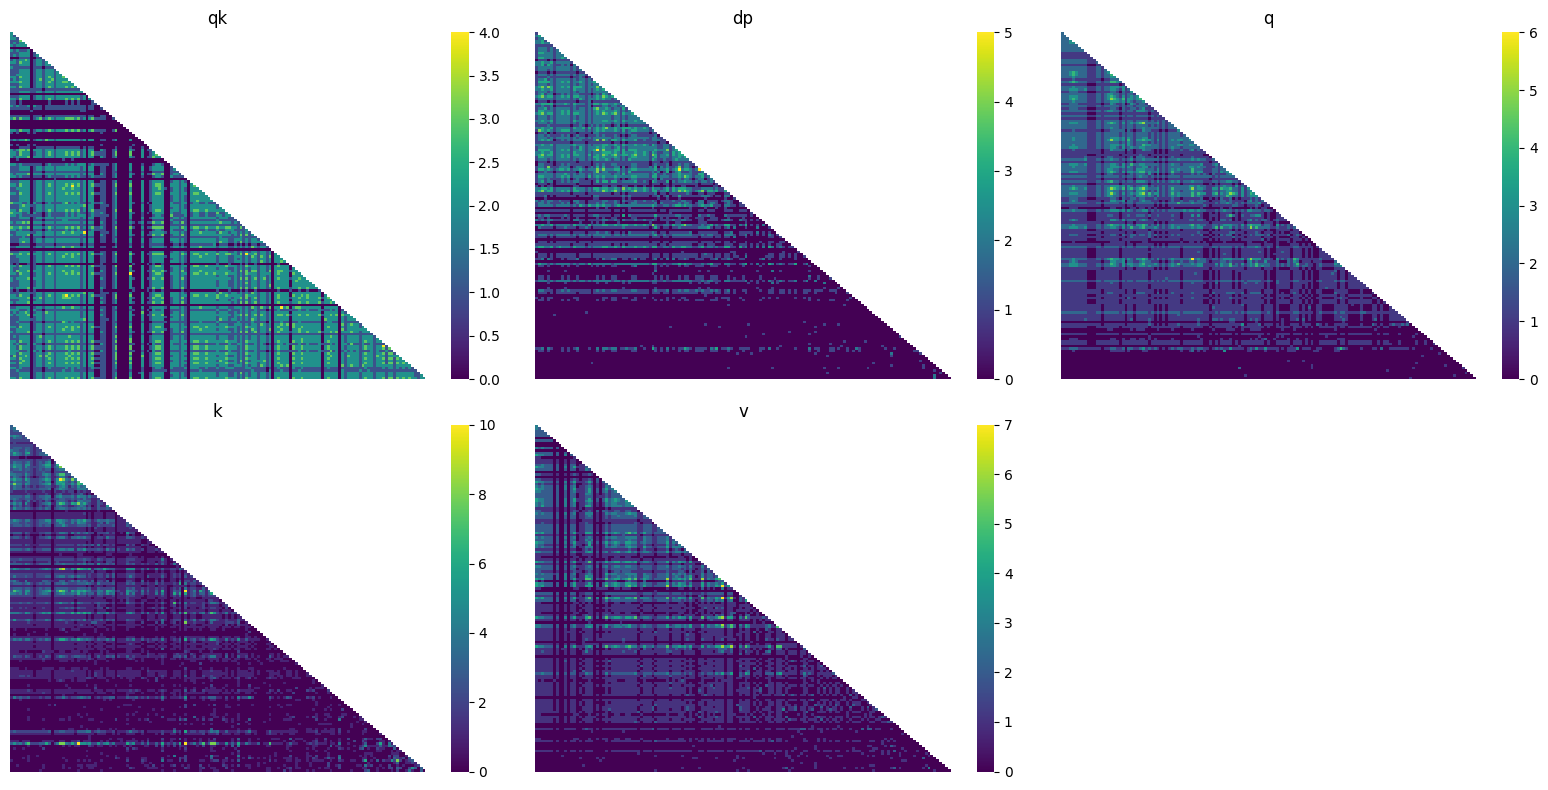

In [13]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(corrupted_shared_tokens, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [16]:
shared_tokens

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,1,11,1,11,2,"11, 262",3,"11, 198, 262",3,"11, 198, 262"
1,0.0,2.0,2,"11, 198",2,"290, 11",2,"11, 262",3,"11, 198, 262",3,"290, 11, 262"
2,0.0,3.0,1,11,1,11,2,"11, 262",2,"11, 262",2,"11, 262"
3,0.0,4.0,1,11,2,"290, 11",2,"11, 262",2,"11, 262",2,"11, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",4,"11, 287, 198, 262",2,"11, 262"
...,...,...,...,...,...,...,...,...,...,...,...,...
10291,140.0,142.0,1,11,0,,0,,0,,0,
10292,140.0,143.0,1,11,0,,0,,0,,0,
10293,141.0,142.0,2,"11, 262",0,,0,,1,23785,0,
10294,141.0,143.0,2,"11, 262",0,,0,,3,"44709, 48366, 40119",0,


In [26]:
c = shared_tokens.compare(corrupted_shared_tokens)
c

qk_count       qk_shared_tokens          dp_count        \
          self other             self    other     self other   
0          1.0   2.0               11  290, 11      NaN   NaN   
2          1.0   2.0               11  290, 11      NaN   NaN   
12         1.0   2.0               11  290, 11      NaN   NaN   
18         1.0   2.0               11  290, 11      NaN   NaN   
20         1.0   2.0               11  290, 11      NaN   NaN   
...        ...   ...              ...      ...      ...   ...   
10280      NaN   NaN              NaN      NaN      1.0   2.0   
10281      NaN   NaN              NaN      NaN      NaN   NaN   
10284      NaN   NaN              NaN      NaN      NaN   NaN   
10288      NaN   NaN              NaN      NaN      NaN   NaN   
10293      NaN   NaN              NaN      NaN      NaN   NaN   

      dp_shared_tokens               q_count       q_shared_tokens        \
                  self         other    self other            self other   
0                  NaN           NaN     NaN   NaN             NaN   NaN   
2                  NaN           NaN     NaN   NaN             NaN   NaN   
12                 NaN           NaN     NaN   NaN             NaN   NaN   
18                 NaN           NaN     NaN   NaN             NaN   NaN   
20                 NaN           NaN     NaN   NaN             NaN   NaN   
...                ...           ...     ...   ...             ...   ...   
10280            11896  11896, 44686     NaN   NaN             NaN   NaN   
10281              NaN           NaN     NaN   NaN             NaN   NaN   
10284              NaN           NaN     NaN   NaN             NaN   NaN   
10288              NaN           NaN     NaN   NaN             NaN   NaN   
10293              NaN           NaN     NaN   NaN             NaN   NaN   

      k_count                 k_shared_tokens                              \
         self other                      self                       other   
0         NaN   NaN                       NaN                         NaN   
2         NaN   NaN                       NaN                         NaN   
12        NaN   NaN                       NaN                         NaN   
18        NaN   NaN                       NaN                         NaN   
20        NaN   NaN                       NaN                         NaN   
...       ...   ...                       ...                         ...   
10280     NaN   NaN                       NaN                         NaN   
10281     2.0   3.0               28819, 3063          3063, 28819, 48711   
10284     NaN   NaN  238, 241, 1878, 119, 121  48527, 241, 1878, 119, 121   
10288     2.0   3.0              26802, 26642         26802, 23593, 26642   
10293     1.0   3.0                     23785         23785, 31538, 34686   

      v_count       v_shared_tokens         
         self other            self  other  
0         NaN   NaN             NaN    NaN  
2         NaN   NaN             NaN    NaN  
12        NaN   NaN             NaN    NaN  
18        NaN   NaN             NaN    NaN  
20        NaN   NaN             NaN    NaN  
...       ...   ...             ...    ...  
10280     0.0   1.0                  11896  
10281     NaN   NaN             NaN    NaN  
10284     NaN   NaN             NaN    NaN  
10288     NaN   NaN             NaN    NaN  
10293     NaN   NaN             NaN    NaN  

[1431 rows x 20 columns]

In [56]:
c.reset_index(inplace=True)
c

index qk_count       qk_shared_tokens          dp_count        \
                self other             self    other     self other   
0         0      1.0   2.0               11  290, 11      NaN   NaN   
1         2      1.0   2.0               11  290, 11      NaN   NaN   
2        12      1.0   2.0               11  290, 11      NaN   NaN   
3        18      1.0   2.0               11  290, 11      NaN   NaN   
4        20      1.0   2.0               11  290, 11      NaN   NaN   
...     ...      ...   ...              ...      ...      ...   ...   
1426  10280      NaN   NaN              NaN      NaN      1.0   2.0   
1427  10281      NaN   NaN              NaN      NaN      NaN   NaN   
1428  10284      NaN   NaN              NaN      NaN      NaN   NaN   
1429  10288      NaN   NaN              NaN      NaN      NaN   NaN   
1430  10293      NaN   NaN              NaN      NaN      NaN   NaN   

     dp_shared_tokens               q_count       q_shared_tokens        \
                 self         other    self other            self other   
0                 NaN           NaN     NaN   NaN             NaN   NaN   
1                 NaN           NaN     NaN   NaN             NaN   NaN   
2                 NaN           NaN     NaN   NaN             NaN   NaN   
3                 NaN           NaN     NaN   NaN             NaN   NaN   
4                 NaN           NaN     NaN   NaN             NaN   NaN   
...               ...           ...     ...   ...             ...   ...   
1426            11896  11896, 44686     NaN   NaN             NaN   NaN   
1427              NaN           NaN     NaN   NaN             NaN   NaN   
1428              NaN           NaN     NaN   NaN             NaN   NaN   
1429              NaN           NaN     NaN   NaN             NaN   NaN   
1430              NaN           NaN     NaN   NaN             NaN   NaN   

     k_count                 k_shared_tokens                              \
        self other                      self                       other   
0        NaN   NaN                       NaN                         NaN   
1        NaN   NaN                       NaN                         NaN   
2        NaN   NaN                       NaN                         NaN   
3        NaN   NaN                       NaN                         NaN   
4        NaN   NaN                       NaN                         NaN   
...      ...   ...                       ...                         ...   
1426     NaN   NaN                       NaN                         NaN   
1427     2.0   3.0               28819, 3063          3063, 28819, 48711   
1428     NaN   NaN  238, 241, 1878, 119, 121  48527, 241, 1878, 119, 121   
1429     2.0   3.0              26802, 26642         26802, 23593, 26642   
1430     1.0   3.0                     23785         23785, 31538, 34686   

     v_count       v_shared_tokens         
        self other            self  other  
0        NaN   NaN             NaN    NaN  
1        NaN   NaN             NaN    NaN  
2        NaN   NaN             NaN    NaN  
3        NaN   NaN             NaN    NaN  
4        NaN   NaN             NaN    NaN  
...      ...   ...             ...    ...  
1426     0.0   1.0                  11896  
1427     NaN   NaN             NaN    NaN  
1428     NaN   NaN             NaN    NaN  
1429     NaN   NaN             NaN    NaN  
1430     NaN   NaN             NaN    NaN  

[1431 rows x 21 columns]

In [60]:
c.reset_index(level=0, drop=True)

index qk_count       qk_shared_tokens          dp_count        \
                self other             self    other     self other   
0         0      1.0   2.0               11  290, 11      NaN   NaN   
1         2      1.0   2.0               11  290, 11      NaN   NaN   
2        12      1.0   2.0               11  290, 11      NaN   NaN   
3        18      1.0   2.0               11  290, 11      NaN   NaN   
4        20      1.0   2.0               11  290, 11      NaN   NaN   
...     ...      ...   ...              ...      ...      ...   ...   
1426  10280      NaN   NaN              NaN      NaN      1.0   2.0   
1427  10281      NaN   NaN              NaN      NaN      NaN   NaN   
1428  10284      NaN   NaN              NaN      NaN      NaN   NaN   
1429  10288      NaN   NaN              NaN      NaN      NaN   NaN   
1430  10293      NaN   NaN              NaN      NaN      NaN   NaN   

     dp_shared_tokens               q_count       q_shared_tokens        \
                 self         other    self other            self other   
0                 NaN           NaN     NaN   NaN             NaN   NaN   
1                 NaN           NaN     NaN   NaN             NaN   NaN   
2                 NaN           NaN     NaN   NaN             NaN   NaN   
3                 NaN           NaN     NaN   NaN             NaN   NaN   
4                 NaN           NaN     NaN   NaN             NaN   NaN   
...               ...           ...     ...   ...             ...   ...   
1426            11896  11896, 44686     NaN   NaN             NaN   NaN   
1427              NaN           NaN     NaN   NaN             NaN   NaN   
1428              NaN           NaN     NaN   NaN             NaN   NaN   
1429              NaN           NaN     NaN   NaN             NaN   NaN   
1430              NaN           NaN     NaN   NaN             NaN   NaN   

     k_count                 k_shared_tokens                              \
        self other                      self                       other   
0        NaN   NaN                       NaN                         NaN   
1        NaN   NaN                       NaN                         NaN   
2        NaN   NaN                       NaN                         NaN   
3        NaN   NaN                       NaN                         NaN   
4        NaN   NaN                       NaN                         NaN   
...      ...   ...                       ...                         ...   
1426     NaN   NaN                       NaN                         NaN   
1427     2.0   3.0               28819, 3063          3063, 28819, 48711   
1428     NaN   NaN  238, 241, 1878, 119, 121  48527, 241, 1878, 119, 121   
1429     2.0   3.0              26802, 26642         26802, 23593, 26642   
1430     1.0   3.0                     23785         23785, 31538, 34686   

     v_count       v_shared_tokens         
        self other            self  other  
0        NaN   NaN             NaN    NaN  
1        NaN   NaN             NaN    NaN  
2        NaN   NaN             NaN    NaN  
3        NaN   NaN             NaN    NaN  
4        NaN   NaN             NaN    NaN  
...      ...   ...             ...    ...  
1426     0.0   1.0                  11896  
1427     NaN   NaN             NaN    NaN  
1428     NaN   NaN             NaN    NaN  
1429     NaN   NaN             NaN    NaN  
1430     NaN   NaN             NaN    NaN  

[1431 rows x 21 columns]

In [57]:
merged_df = pd.merge(shared_tokens, c, left_index=True, right_on='index_diff', how='left')
merged_df

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

## logit contribution heads